# 1. Install and load needed packages.

In [4]:
!pip3 install -q --upgrade ismi_utils
!pip install imagecodecs
!pip3 install torchsummary

In [5]:
import json
import os

# import libraries
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"

import random
# import shutil
# from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import torch
import torch.nn as nn
# from ismi_utils import download_data
from PIL import Image
from tqdm import tqdm
import pickle
from scipy.ndimage import gaussian_filter
from matplotlib import cm
import scipy
from scipy import signal
from skimage.feature import peak_local_max
from scipy import ndimage

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 12)

# 2. Load data

In [6]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Open coco file to get detections and corresponding images
with open('/content/drive/MyDrive/tissue-cells/tiger-coco.json') as f:
    tiger_coco = json.load(f)
images = tiger_coco['images']
annotations = tiger_coco['annotations']

In [8]:
# Open the file with the indexes of the false positive pixels
with open("/content/drive/MyDrive/tissue-cells/falsepositive_samples", "rb") as fp:
  falsepositive = pickle.load(fp)

# 3. Creating segmentation masks and loading in images.

In [9]:
# Lists to add images and segmentation masks
train_imgs = []
train_lbls = []

for i in images:
  # Load in image
  image_id = i['id']
  image_file_name = i['file_name']
  image = plt.imread('/content/drive/MyDrive/tissue-cells'+ image_file_name[1:])
  train_imgs.append(image)

  # Create segmentation mask
  ## Gather bounding boxes of given image
  bounding_boxes = []
  for a in annotations:
    if a['image_id'] == image_id:
      bounding_boxes.append(a)

  ## Create circles based on founded bounding boxes
  labels_arr=[]
  labels = np.zeros_like(image)[:,:,0]
  if bounding_boxes:
    for box in bounding_boxes:
        x, y, w, h = box['bbox']

        middle_y = y+(0.5*h)
        middle_x = x+(0.5*w)

        radiusx = 0.5*w
        radiusy = 0.5*h

        # Initialize lists to store pixel values within the circle
        pixel_values = []
        y_shape, x_shape, c_shape = image.shape
        for i in range(int(middle_y - radiusy), int(middle_y + radiusy)):
          for j in range(int(middle_x - radiusx), int(middle_x + radiusx)):
              # Calculate the distance of the current pixel from the circle's center
              distance = np.sqrt((i - middle_y)**2 + (j - middle_x)**2)
              # Check if the pixel lies within the inner circle's boundary
              if distance <= radiusx*4/5:
                  if i<y_shape and i>0 and j<x_shape and j > 0:
                    labels[i, j] = 2
              # Check if the pixel lies within the outer circle boundary
              elif distance<=radiusx:
                  if i<y_shape and i>0 and j<x_shape and j > 0:
                    labels[i, j] = 1
    labels = labels[:,:,None]
    train_lbls.append(labels)
  else:
    train_lbls.append( np.zeros_like(image)[:,:,0][:,:,None])


# 4. Creation of different datasets: train, validation and test.

In [10]:
# Defining the number of validation and test images
n_validation_imgs = 180
n_test_imgs = 180

In [11]:
# The following class will be used to handle training, test and validation datasets
class DataSet:
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls

    def __post_init__(self):
        if self.lbls is not None and len(self.imgs) != len(self.lbls):
            raise ValueError("The number of images and labels should be the same")
        if len(self.imgs) == 0:
            raise ValueError("No images were provided!")

    def show_image(self, i):
        if self.lbls is not None:
            f, axes = plt.subplots(1, 2)
            for ax, im, t in zip(axes,
                                 (self.imgs[i], self.lbls[i]),
                                 ('RGB image','Manual annotation')):
                ax.imshow(im, cmap='gray')
                ax.set_title(t)
        else:
            f, axes = plt.subplots(1, 1)
            for ax, im, t in zip(axes,
                                 (self.imgs[i]),
                                 ('RGB image')):
                ax.imshow(im, cmap='gray')
                ax.set_title(t)
        plt.show()

In [12]:
# The first images are used as validation set
validation_data = DataSet(train_imgs[:n_validation_imgs], train_lbls[:n_validation_imgs])

# The next images are used as test set
test_data = DataSet(train_imgs[n_validation_imgs:n_validation_imgs + n_test_imgs], train_lbls[n_validation_imgs:n_validation_imgs + n_test_imgs])

# The rest of the data is used as training
train_data = DataSet(train_imgs[n_validation_imgs + n_test_imgs:], train_lbls[n_validation_imgs + n_test_imgs:])

In [13]:
# DataLoaders need a Dataset class as input
# We simply wrap the training data and labels in such a class and give it as input to a DataLoader
class CustomDataset(DataSet):
    def __init__(self, data, labels, transform=None):
        self.images = data
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images
        img = []
        lbls = []
        if self.transform:
            for img in image:
              img.append(self.transform(img))
        self.images = np.array(images)
        return (image, label)

    def __len__(self):
        return len(self.labels)

In [14]:
import torchvision
import torchvision.transforms as transforms

composed = transforms.Compose([torchvision.transforms.ToTensor(),
                                     torchvision.transforms.RandomRotation(23),
                                     torchvision.transforms.RandomAffine(degrees=0.0, translate=(0.2, 0.2))])


# the rest as training
train_custom = CustomDataset(train_imgs[n_validation_imgs + n_test_imgs:], train_lbls[n_validation_imgs + n_test_imgs:],transform=composed)
train_data_augmented = DataSet(train_custom.images, train_custom.labels)


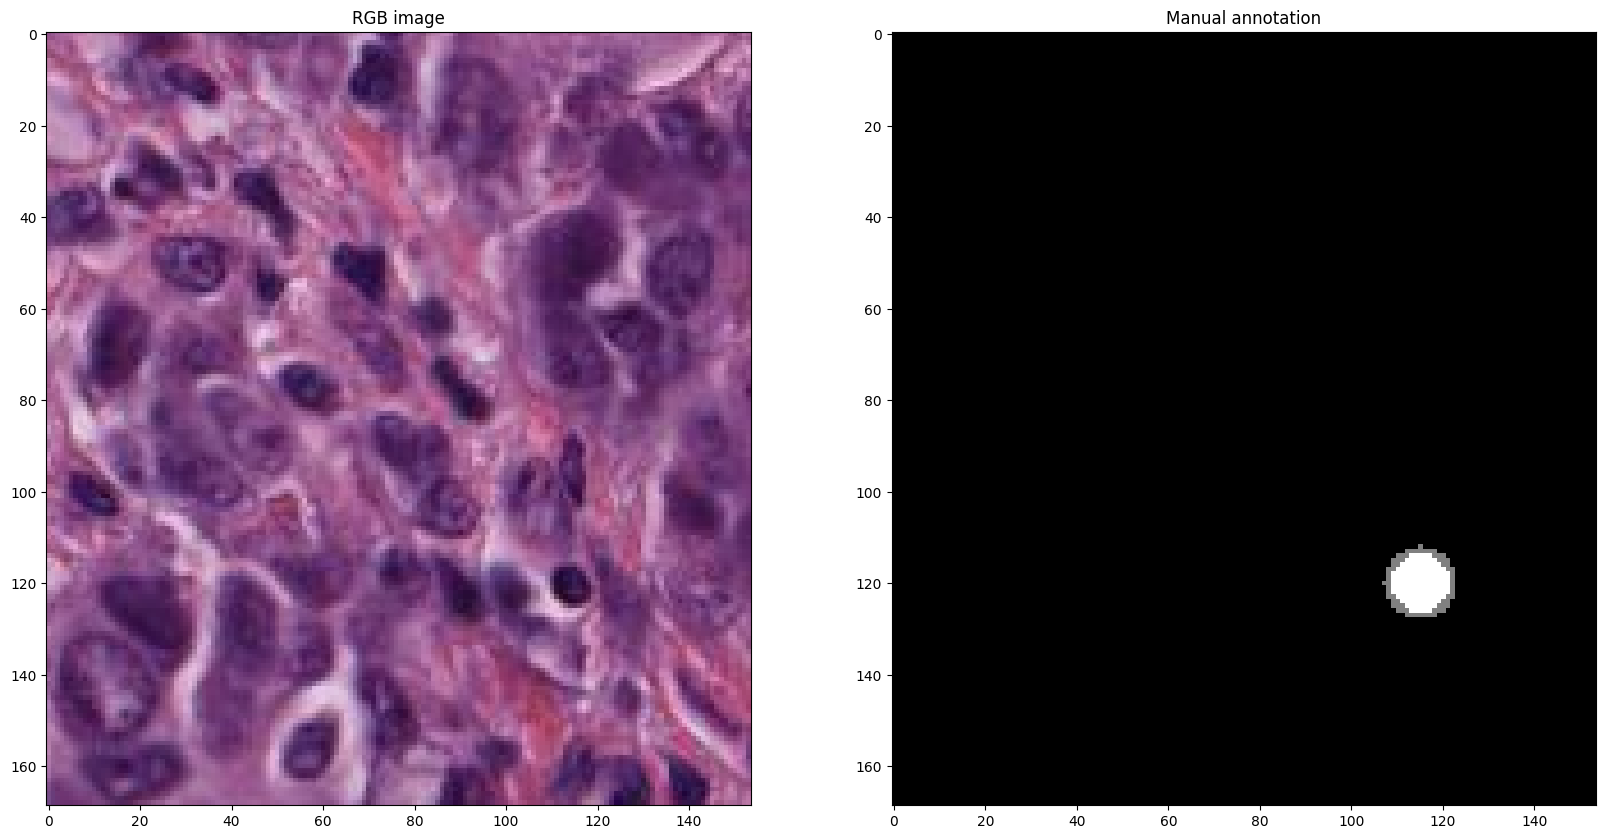

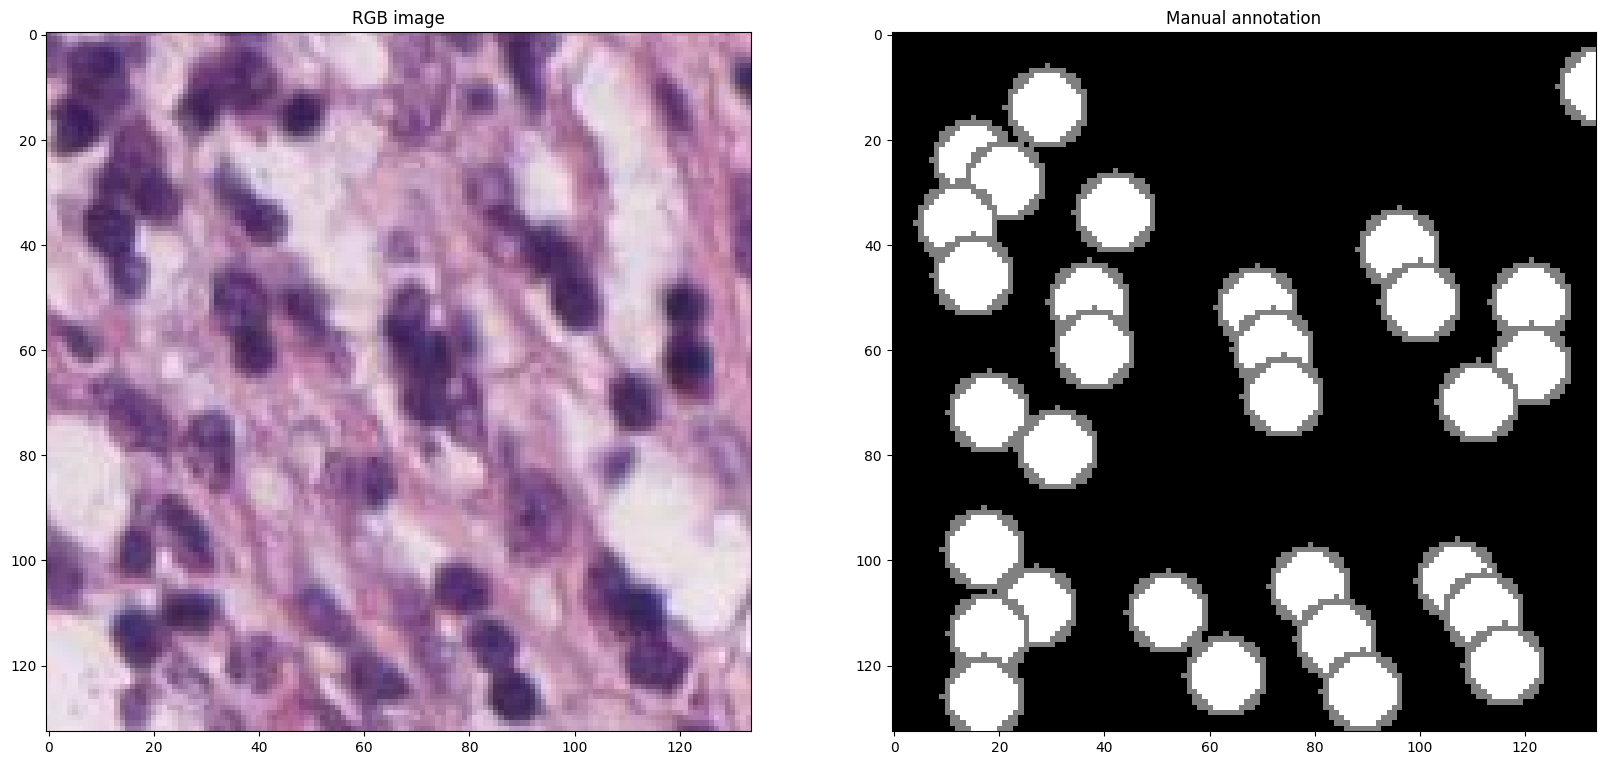

In [15]:
# Inspect a few loaded images
matplotlib.rcParams['figure.figsize'] = (20, 12)
validation_data.show_image(0) # change this parameter to try a few images
train_data.show_image(0) # change this parameter to try a few images

# 5. Build a patch extractor
Multiple functions are build so that the right patches can be extracted from the dataset.

In [16]:
# This class will extract patches when the location is given.
class PatchExtractor:

    def __init__(self, patch_size, horizontal_flipping=True):
        self.patch_size = patch_size
        self.horizontal_flipping = horizontal_flipping

    def get_patch(self, image, labels, location):
        '''
        image: a numpy array representing the input image,
        labels: a numpy array representing the corresponding segmentation annotation
        location: a tuple with an y and x coordinate

        return a patch from the image at `location`, representing the center of the patch, and the corresponding label patch
        if self.horizontal_flipping = True, there is a 50% chance the patch is horizontally flipped
        '''
        y, x = location
        py, px = self.patch_size

        # - patch should be a numpy array of size <h, w>
        # - the patch should be normalized (intensity values between 0-1)

        # YOUR CODE HERE
        img_patch = image[int(y-((py-1)/2)):int(y+((py-1)/2))+1,int(x-((px-1)/2)):int(x+((px-1)/2))+1,:]

        label_patch = labels[int(y-((py-1)/2)):int(y+((py-1)/2))+1,int(x-((px-1)/2)):int(x+((px-1)/2))+1,:]
        # - if self.flipping = True, there should be a 50% chance to apply a horizontal flip to the patch
        if self.horizontal_flipping:

            # There is a 50% chance to apply a horizontal flip to the patch
            do_flipping = random.choice([True, False])
            # - if do_flipping == True, flip the patch horizontally
            if do_flipping:

                # The images are flipped
                img_patch_flipped = np.fliplr(img_patch)
                label_patch_flipped = np.fliplr(label_patch)

                img_patch = img_patch_flipped
                label_patch = label_patch_flipped
        assert img_patch.ndim == label_patch.ndim
        return img_patch, label_patch

In [17]:
# This function will pad images in a list so that locations at the border of the image also can be chosen
def pad(images, patch_size):
    '''
    images: list of images (numpy arrays)
    returns a padded version of the images, with a border of half the patch_size around each image
    '''
    half_py, half_px = [p//2 for p in patch_size]
    paddings = ((half_py, half_py), (half_px, half_px), (0, 0))

    padded_images = []

    # Iterate over each image
    for image in images:
        # Pad the current image
        padded_image = np.pad(image, pad_width=paddings, mode='constant')
        # Append the padded image to the list
        padded_images.append(padded_image)

    return padded_images

In [18]:
# This function will pad a single image
def pad_single(image, patch_size):
    '''
    image: image (numpy array)
    returns a padded version of the image, with a border of half the patch_size around each image
    '''
    half_py, half_px = [p//2 for p in patch_size]
    paddings = ((half_py, half_py), (half_px, half_px), (0, 0))

    return np.pad(image, pad_width=paddings, mode='constant')

In [19]:
# This class will sample 50% locations with label 1 or 2, 30% false positive indexes, 20% negative locations
class BalancedSampler:

    def __init__(self, lbls,border_pad_size,falsepositive):
        self.lbls = lbls
        self.border_pad_size = border_pad_size
        self.falsepositive = falsepositive

    def generate_sample_locations(self,validation):
        n_images = len(self.lbls)
        locations = []

        # With change decide if the sample should be positive, false positive or negative
        pos_neg = random.sample([0,1,2,3,4,5,6,7,8,9],1)[0]
        # If the sample should be positive
        if pos_neg>=5:
          # A new image is found if no positive pixels are found
          found_pos = False
          while found_pos!=True:
            image_number = np.random.randint(0,n_images)
            lbl = self.lbls[image_number]

            x_shape,y_shape,i_shape = lbl.shape
            x_shape = x_shape-self.border_pad_size[0]
            y_shape = y_shape-self.border_pad_size[1]

            msk = np.ones((x_shape,y_shape,1))
            msk = pad_single(msk,self.border_pad_size)

            try:
              pos = np.asarray(np.where((msk>0)&(lbl > 0))).T.tolist()
              sample = random.sample(pos,1)
              found_pos=True
            except:
              found_pos=False
          sample = sample[0]
          sample.append(image_number)
        # If the sample should be a false positive
        elif pos_neg>=2 and validation==False:
          sample = random.sample(falsepositive,1)
          sample = sample[0]
          y_,x_ = self.border_pad_size[0]/2,self.border_pad_size[1]/2
          sample = [sample[0]+y_,sample[1]+x_,1,sample[3]]
        # If the sample should be negative
        else:
          image_number = np.random.randint(0,n_images)
          lbl = self.lbls[image_number]

          x_shape,y_shape,i_shape = lbl.shape
          x_shape = x_shape-self.border_pad_size[0]
          y_shape = y_shape-self.border_pad_size[1]

          msk = np.ones((x_shape,y_shape,1))
          msk = pad_single(msk,self.border_pad_size)
          neg = np.asarray(np.where((msk>0)&(lbl == 0))).T.tolist()
          sample = random.sample(neg,1)
          sample = sample[0]
          sample.append(image_number)

        locations.append(sample)
        # return the found location
        return locations


In [20]:
# This class will create a dataset where the patches can be extracted from, this class is needed for the used class UNetPatchDataset
class PatchDataset(torch.utils.data.Dataset):

    def __init__(self, patch_extractor, dataset, border_pad_size, batch_size,falsepositive,validation):
        self.patch_extractor = patch_extractor
        self.validation= validation

        # the images are padded with half the patch-size around the border
        # this way, we don't risk extracting patches from the border, that extend beyond the original image
        self.imgs = pad(dataset.imgs, border_pad_size)
        self.lbls = pad(dataset.lbls, border_pad_size)
        self.patch_location_sampler = BalancedSampler(self.lbls,border_pad_size,falsepositive)
        self.batch_size = batch_size

    def __len__(self):
        # Note: take the max of the length of the images and the batch_size to allow batches larger than the number of images
        return max(len(self.imgs), self.batch_size)

    def __getitem__(self, index):
        '''generate a sample from the dataset'''
        # sample a random image and location
        locations = self.patch_location_sampler.generate_sample_locations(self.validation)
        y, x,_,i = locations[0]

        image_patch, label_patch = patch_extractor_train.get_patch(self.imgs[i], self.lbls[i], (y,x))
        # get the label at the center of the patch
        if label_patch.shape[0] % 2 == 0 or label_patch.shape[1] % 2 == 0:
            raise ValueError("label_patch should have an odd size in both dimensions to have a single center pixel")

        label = (label_patch[label_patch.shape[0] // 2, label_patch.shape[1] // 2])

        # convert mask to a one-hot encoded classification label
        label = np.eye(3)[int(label)]

        # move the color channel to the first dimension
        image = np.moveaxis(image_patch, -1, 0).copy()

        # add two dummy dimensions to the label for compatibility with pytorch
        label = np.expand_dims(np.expand_dims(label, -1), -1)

        return image, label

In [21]:
# This class will create a dataset where the patches can be extracted from, this class is based on the class PatchDataset
class UNetPatchDataset(PatchDataset):

    def __init__(self, patch_extractor, dataset, border_pad_size, batch_size,falsepositive,validation):
        super(UNetPatchDataset, self).__init__(patch_extractor, dataset, border_pad_size, batch_size,falsepositive,validation)
        self.dataset = dataset

    def __getitem__(self, index):
        '''
        return image patches (x) with corresponding label patches (y) in one-hot structure
        '''
        x_data = np.zeros((3, *self.patch_extractor.patch_size))
        y_data = np.zeros((3, *self.patch_extractor.patch_size))  # one-hot encoding

        locations = self.patch_location_sampler.generate_sample_locations(self.validation)
        y, x,_,i = locations[0]

        img_, label_ = patch_extractor_train.get_patch(self.imgs[i], self.lbls[i],(y,x))

        x_data = np.moveaxis(img_, -1, 0)
        y_data[0] = (label_[:,:,0]==0)
        y_data[1] = (label_[:,:,0]==1)
        y_data[2] = (label_[:,:,0]==2)

        return x_data.copy(), y_data.copy()

# 6. The following functions will be used for training the network

In [22]:
# This function will give the number of parameters in a network.
def count_params(network):
    return sum(p.numel() for p in network.parameters())

In [23]:
# This class will train a given model
class Trainer():

    def __init__(self, network, optimizer, loss_function, name, batch_size):
        """
        Make training set
        Notes:
          * network - The network you have created before, should be a nn.Module()
          * optimizer - The optimizer you have created before.
          * loss_function - The crossentropy loss function
          * name: To identify which model came from which task, you can give your models
          a name so you can distinguish them later on. Give them clear distinguishable names to make it easy for yourself
        """

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = network.to(self.device)
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.name = name
        self.network_filepath = f'{name}_best_model.pt'
        self.running_train_loss = []
        self.runnin_val_loss = []
        self.running_train_acc = []
        self.running_val_acc = []
        self.best_val_loss = np.inf
        self.batch_size = batch_size

    def train_network(self, train_data, val_data, steps_per_epoch, epochs):
        # Contains the code to train the network and calculate performance metrics

        for epoch in tqdm(range(epochs), position=0, leave=False, desc="Epochs"):

            self._train_one_epoch(train_data, steps_per_epoch=steps_per_epoch)

            """
            EXERCISE: Evaluate the network on the training and validation set.
            Uncomment the following lines of Python and replace the None value
            within the function to calculate the training and validation performance.
            """

            # YOUR CODE HERE
            # Get training loss and accuracy
            train_loss, train_acc = self.validate_dataset(train_data)

            # Get validation loss and accuracy
            val_loss, val_acc = self.validate_dataset(val_data)



            tqdm.write(f"Epoch {epoch}: train loss: {train_loss}, train accuracy: {train_acc}, val loss: {val_loss}, val accuracy: {val_acc}")

            self.running_train_loss.append(train_loss)
            self.runnin_val_loss.append(val_loss)
            self.running_train_acc.append(train_acc)
            self.running_val_acc.append(val_acc)

            if val_loss < self.best_val_loss:
                # Look up how to save your network
                self.best_val_loss = val_loss
                self._save_best_network()

        self._plot_statistics()

    def _train_one_step(self, dataloader):
        # Set the network to train mode
        self.network.train()
        for x, y in dataloader:
            x = x.float().to(self.device)
            y = y.to(self.device)
            loss, y_pred = self._evaluate_batch(x, y)

            # Optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            break

    def _train_one_epoch(self, dataloader, steps_per_epoch):
        for step in range(steps_per_epoch):
            print('Step: ',step)
            self._train_one_step(dataloader)

    def validate_dataset(self, dataloader):
        total_loss = 0
        correct = 0

        # Set the network into eval mode (changes how dropout and BN work)
        self.network.eval()

        # perform an evaluation pass
        accuracies = []
        with torch.no_grad():
            for x, y in dataloader:
                x = x.float().to(self.device)
                y = y.to(self.device)

                # Evaluate the model and get the batch loss and predictions
                loss_value, y_pred_class = self._evaluate_batch(x, y)

                # Get the number of correct predictions and accumulate
                batch_accuracy = np.mean((y_pred_class == torch.argmax(y, dim=1)).cpu().detach().numpy())
                accuracies.append(batch_accuracy)

                # Accumulate loss
                total_loss += loss_value.cpu().detach().numpy()

        # The loss is meaned over the batches, to get the proper loss, multiple by the batch size and divide by number of images
        total_loss = (total_loss * dataloader.batch_size) / (dataloader.batch_size * len(dataloader))
        accuracy = np.mean(accuracies)
        return total_loss, accuracy

    def _evaluate_batch(self, x, y):
        # Get logits from the model
        # print(f'Type input: {x.dtype}')
        y_pred = self.network(x)

        # binarize the probabilities to predictions
        y_pred_class = torch.argmax(y_pred, dim=1)

        # Calculate the loss
        # print(f'Prediction: {y_pred.shape}, Label: {y.float().shape}')
        loss_value: torch.Tensor = self.loss_function(y_pred, y.float())

        # print(f'X: {x.shape}, Y: {y.shape}, Y_pred: {y_pred.shape}, Y_pred_class: {y_pred_class.shape}')
        return loss_value, y_pred_class

    def _save_best_network(self):
        torch.save(self.network, self.network_filepath)

    def load_best_network(self):
        self.network = self._load_best_network()

    def _load_best_network(self):
      return torch.load(self.network_filepath)

    def _load_best_saved_network(self):
        return torch.load(self.network_filepath)

    def _predict(self, x):
        self.network.eval()
        with torch.no_grad():
            otp = self.network(x.to(self.device))
        return otp

    def _predict_batch(self, x):
        outputs = []
        for img in x:
            output = self._predict(img)
            outputs.append(output)
        return outputs

    def _plot_statistics(self):
        # Helper function, plots the training and validation curves
        f, ax = plt.subplots(figsize=(10, 5))
        ax.plot(range(len(self.running_train_loss)), self.running_train_loss , 'b', label="training loss")
        ax.plot(range(len(self.runnin_val_loss)), self.runnin_val_loss, 'c', label="validation loss")
        ax.plot(range(len(self.running_train_acc)), self.running_train_acc, 'g', label="training accuracy")
        ax.plot(range(len(self.running_val_acc)), self.running_val_acc, 'r', label="validation accuracy")
        ax.set_xlabel('step')
        ax.set_ylabel('loss')
        ax.legend(loc='best')
        ax.set_title(f'Best validation loss = {self.best_val_loss:.2f}')
        plt.show()


In [24]:
# The loss function is defined here
loss_function = nn.CrossEntropyLoss()

In [25]:
loss_function2= nn.MSELoss()

# 7. The network

In [26]:
# The network which will be trained
class UNet1(nn.Module):
    def __init__(self):
        super(UNet1, self).__init__()

        # Define the first set of layers
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.p1 = nn.MaxPool2d(kernel_size=2)

        # Define the second set of layers
        self.c2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.p2 = nn.MaxPool2d(kernel_size=2)

        # Define the third set of layers
        self.c3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.p3 = nn.MaxPool2d(kernel_size=2)

        # Define the fourth set of layers
        self.c4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        # Define the up-convolution and concatenation layers
        self.u2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.u3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm3 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.u4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.cm4 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        # Define the output layer
        self.predictions = nn.Conv2d(16, 3, kernel_size=1)

    def forward(self, x):
        # YOUR CODE HERE

        c1_out = self.c1(x)
        p1_out = self.p1(c1_out)

        c2_out = self.c2(p1_out)
        p2_out = self.p2(c2_out)

        c3_out = self.c3(p2_out)
        p3_out = self.p3(c3_out)

        c4_out = self.c4(p3_out)

        u2_out = self.u2(c4_out)

        concat2 = torch.cat([u2_out, c3_out], dim=1)
        cm2_out = self.cm2(concat2)

        u3_out = self.u3(cm2_out)
        concat3 = torch.cat([u3_out, c2_out], dim=1)
        cm3_out = self.cm3(concat3)

        u4_out = self.u4(cm3_out)
        concat4 = torch.cat([u4_out, c1_out], dim=1)
        cm4_out = self.cm4(concat4)

        predictions = self.predictions(cm4_out)


        return predictions

In [27]:
unet_1 = UNet1()
print(f"Number of parameters: {count_params(unet_1)}")

Number of parameters: 487331


# 8. Hyperparameters

In [28]:
# Set if you want to train the model or take the best one found
TRAIN_MODEL = False

# Hyperparameter settings
learning_rate = 0.001
patch_size = (32,32)
batch_size = 12
steps_per_epoch = 10
epochs = 60

In [29]:
# Setting optimizer
optimizer = torch.optim.Adam(unet_1.parameters(), lr=learning_rate)

# 9. Training the model

In [30]:
# The datasets are created
patch_extractor_train = PatchExtractor(patch_size=patch_size, horizontal_flipping=True)
patch_dataset_train = UNetPatchDataset(patch_extractor=patch_extractor_train, dataset=train_data, border_pad_size=patch_extractor_train.patch_size, batch_size=batch_size,falsepositive=falsepositive,validation=False)
dataloader_train = torch.utils.data.DataLoader(patch_dataset_train, batch_size)
patch_extractor_val = PatchExtractor(patch_size=patch_size, horizontal_flipping=False)
patch_dataset_val = UNetPatchDataset(patch_extractor=patch_extractor_val, dataset=validation_data, border_pad_size=patch_size, batch_size=batch_size,falsepositive=falsepositive,validation=True)
dataloader_val = torch.utils.data.DataLoader(patch_dataset_val, batch_size)

Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:   2%|▏         | 1/60 [01:26<1:25:12, 86.65s/it]

Epoch 0: train loss: 0.2339309322552418, train accuracy: 0.6896341021337178, val loss: 0.2211827665567398, val accuracy: 0.747629123263889
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:   3%|▎         | 2/60 [02:49<1:21:43, 84.55s/it]

Epoch 1: train loss: 0.18095755307223854, train accuracy: 0.7717297056617924, val loss: 0.16511461436748504, val accuracy: 0.8426595052083333
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:   5%|▌         | 3/60 [04:18<1:22:15, 86.60s/it]

Epoch 2: train loss: 0.1314588402082601, train accuracy: 0.7963964221269216, val loss: 0.10900087853272757, val accuracy: 0.8560655381944444
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:   7%|▋         | 4/60 [05:43<1:20:12, 85.95s/it]

Epoch 3: train loss: 0.11987041987068071, train accuracy: 0.8109134978733128, val loss: 0.09679435392220816, val accuracy: 0.8652398003472221
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:   8%|▊         | 5/60 [07:05<1:17:32, 84.60s/it]

Epoch 4: train loss: 0.1141188919661552, train accuracy: 0.8150295605139202, val loss: 0.09026562174161275, val accuracy: 0.8695692274305558
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  10%|█         | 6/60 [08:25<1:14:38, 82.94s/it]

Epoch 5: train loss: 0.1205366679767924, train accuracy: 0.7953217273622047, val loss: 0.09240122959017753, val accuracy: 0.8593098958333333
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  12%|█▏        | 7/60 [09:45<1:12:23, 81.95s/it]

Epoch 6: train loss: 0.11696171528828425, train accuracy: 0.8025406736267341, val loss: 0.09021934345364571, val accuracy: 0.8591362847222223
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  13%|█▎        | 8/60 [10:54<1:07:20, 77.71s/it]

Epoch 7: train loss: 0.11575513532546562, train accuracy: 0.8002533313706881, val loss: 0.09493138641119003, val accuracy: 0.8455512152777778
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  15%|█▌        | 9/60 [12:01<1:03:14, 74.41s/it]

Epoch 8: train loss: 0.1165157261443889, train accuracy: 0.7969144542967285, val loss: 0.08513810485601425, val accuracy: 0.8702256944444444
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  17%|█▋        | 10/60 [13:31<1:05:56, 79.14s/it]

Epoch 9: train loss: 0.11069427055167401, train accuracy: 0.8082462592566553, val loss: 0.08147084563970566, val accuracy: 0.8721028645833334
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  18%|█▊        | 11/60 [14:50<1:04:38, 79.16s/it]

Epoch 10: train loss: 0.11016338506317515, train accuracy: 0.8062585316483876, val loss: 0.07510137135783831, val accuracy: 0.8775933159722222
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  20%|██        | 12/60 [15:56<1:00:09, 75.19s/it]

Epoch 11: train loss: 0.11493541224030998, train accuracy: 0.7952236866387795, val loss: 0.08227139314015706, val accuracy: 0.8700629340277776
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  22%|██▏       | 13/60 [17:00<56:18, 71.88s/it]  

Epoch 12: train loss: 0.10611418529054312, train accuracy: 0.8122994330298556, val loss: 0.08846042056878407, val accuracy: 0.8499348958333334
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  23%|██▎       | 14/60 [18:28<58:49, 76.73s/it]

Epoch 13: train loss: 0.10795754766253036, train accuracy: 0.8063384471960536, val loss: 0.0813304585715135, val accuracy: 0.8647677951388888
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  25%|██▌       | 15/60 [19:39<56:20, 75.13s/it]

Epoch 14: train loss: 0.11065983124018654, train accuracy: 0.8027229323385359, val loss: 0.0799726980427901, val accuracy: 0.875830078125
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  27%|██▋       | 16/60 [20:45<52:53, 72.11s/it]

Epoch 15: train loss: 0.10803935524281555, train accuracy: 0.8050569606533559, val loss: 0.08114708264668782, val accuracy: 0.8603298611111112
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  28%|██▊       | 17/60 [22:20<56:45, 79.21s/it]

Epoch 16: train loss: 0.10976254004310435, train accuracy: 0.7998727942210347, val loss: 0.08731233502427736, val accuracy: 0.8483289930555556
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  30%|███       | 18/60 [23:48<57:16, 81.82s/it]

Epoch 17: train loss: 0.1069240009221505, train accuracy: 0.8062889233572366, val loss: 0.08049116556843122, val accuracy: 0.8656955295138888
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  32%|███▏      | 19/60 [25:05<54:51, 80.29s/it]

Epoch 18: train loss: 0.11048501618499831, train accuracy: 0.7991757072846363, val loss: 0.08912623325983683, val accuracy: 0.8462565104166667
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  33%|███▎      | 20/60 [26:27<53:55, 80.90s/it]

Epoch 19: train loss: 0.10449931051904761, train accuracy: 0.8080320526340456, val loss: 0.08272073169549306, val accuracy: 0.8519042968750001
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  35%|███▌      | 21/60 [27:56<54:11, 83.37s/it]

Epoch 20: train loss: 0.10266457292742616, train accuracy: 0.8119480060109676, val loss: 0.08770281250278154, val accuracy: 0.842355685763889
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  37%|███▋      | 22/60 [28:53<47:44, 75.38s/it]

Epoch 21: train loss: 0.1063501695244331, train accuracy: 0.8025060710184665, val loss: 0.07859568496545156, val accuracy: 0.8639919704861112
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  38%|███▊      | 23/60 [30:23<49:04, 79.58s/it]

Epoch 22: train loss: 0.1082315180069349, train accuracy: 0.7964829286475908, val loss: 0.07603381226460139, val accuracy: 0.8655273437499998
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  40%|████      | 24/60 [31:47<48:35, 80.98s/it]

Epoch 23: train loss: 0.10693618587738886, train accuracy: 0.8001155617266591, val loss: 0.08545851856470107, val accuracy: 0.8427300347222222
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  42%|████▏     | 25/60 [32:55<45:04, 77.27s/it]

Epoch 24: train loss: 0.1055142661248605, train accuracy: 0.801997192977831, val loss: 0.09027914901574453, val accuracy: 0.8321614583333333
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  43%|████▎     | 26/60 [34:20<45:00, 79.44s/it]

Epoch 25: train loss: 0.10383564342311986, train accuracy: 0.8059063722991657, val loss: 0.07356511652469636, val accuracy: 0.8683702256944446
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  45%|████▌     | 27/60 [35:45<44:37, 81.15s/it]

Epoch 26: train loss: 0.10409235930818272, train accuracy: 0.8001321307004593, val loss: 0.0773364745080471, val accuracy: 0.8597167968749999
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  47%|████▋     | 28/60 [36:56<41:37, 78.05s/it]

Epoch 27: train loss: 0.09871149233241719, train accuracy: 0.8124692421259843, val loss: 0.08264281153678894, val accuracy: 0.8434190538194444
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  48%|████▊     | 29/60 [38:21<41:26, 80.21s/it]

Epoch 28: train loss: 0.10253950924150587, train accuracy: 0.8038364406109394, val loss: 0.07286666333675385, val accuracy: 0.8634548611111111
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  50%|█████     | 30/60 [39:53<41:54, 83.82s/it]

Epoch 29: train loss: 0.10021334830818214, train accuracy: 0.8106554429719723, val loss: 0.083255256464084, val accuracy: 0.8490180121527776
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  52%|█████▏    | 31/60 [41:17<40:32, 83.90s/it]

Epoch 30: train loss: 0.10086777122823272, train accuracy: 0.806069590422291, val loss: 0.06754482885201772, val accuracy: 0.8771430121527778
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  53%|█████▎    | 32/60 [42:36<38:23, 82.27s/it]

Epoch 31: train loss: 0.10229766178201502, train accuracy: 0.7994026381467941, val loss: 0.07791082362333933, val accuracy: 0.8488172743055556
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  55%|█████▌    | 33/60 [44:02<37:34, 83.51s/it]

Epoch 32: train loss: 0.09959764065822278, train accuracy: 0.8046550943827334, val loss: 0.07929018934567769, val accuracy: 0.845339626736111
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  57%|█████▋    | 34/60 [45:24<35:56, 82.92s/it]

Epoch 33: train loss: 0.09902696009344003, train accuracy: 0.8014503253011341, val loss: 0.08001341049869855, val accuracy: 0.8394259982638891
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  58%|█████▊    | 35/60 [46:39<33:36, 80.66s/it]

Epoch 34: train loss: 0.09571470622354605, train accuracy: 0.8073965729869704, val loss: 0.06644898653030396, val accuracy: 0.8781846788194445
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  60%|██████    | 36/60 [48:14<33:57, 84.90s/it]

Epoch 35: train loss: 0.0957351873416131, train accuracy: 0.8073960237392199, val loss: 0.0781892237563928, val accuracy: 0.8416720920138889
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  62%|██████▏   | 37/60 [49:45<33:12, 86.63s/it]

Epoch 36: train loss: 0.09706432442730806, train accuracy: 0.8024174590480876, val loss: 0.07065351431568463, val accuracy: 0.8602593315972221
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  63%|██████▎   | 38/60 [51:01<30:34, 83.40s/it]

Epoch 37: train loss: 0.1000270245406102, train accuracy: 0.8068475998605642, val loss: 0.07347108448545138, val accuracy: 0.8683159722222222
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  65%|██████▌   | 39/60 [52:18<28:34, 81.66s/it]

Epoch 38: train loss: 0.09952716822699299, train accuracy: 0.7990832505800055, val loss: 0.07778764242927233, val accuracy: 0.8437662760416667
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  67%|██████▋   | 40/60 [53:38<27:05, 81.26s/it]

Epoch 39: train loss: 0.09760487619347459, train accuracy: 0.8014257006936633, val loss: 0.07824870049953461, val accuracy: 0.850515407986111
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  68%|██████▊   | 41/60 [55:02<25:58, 82.03s/it]

Epoch 40: train loss: 0.09319867759825677, train accuracy: 0.809204421957021, val loss: 0.07665718620022138, val accuracy: 0.8484537760416664
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  70%|███████   | 42/60 [56:21<24:17, 80.97s/it]

Epoch 41: train loss: 0.09263470616396957, train accuracy: 0.8042081897965878, val loss: 0.07517375176151593, val accuracy: 0.839301215277778
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  72%|███████▏  | 43/60 [57:32<22:06, 78.04s/it]

Epoch 42: train loss: 0.09359494364989085, train accuracy: 0.8075315048509561, val loss: 0.07366424749294917, val accuracy: 0.8487575954861111
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  73%|███████▎  | 44/60 [58:42<20:09, 75.59s/it]

Epoch 43: train loss: 0.10103979991294268, train accuracy: 0.7987147968808586, val loss: 0.07878003393610318, val accuracy: 0.8431369357638888
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  75%|███████▌  | 45/60 [59:59<19:02, 76.19s/it]

Epoch 44: train loss: 0.0980969637515038, train accuracy: 0.8007861016884608, val loss: 0.08201639850934346, val accuracy: 0.8320855034722224
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  77%|███████▋  | 46/60 [1:01:17<17:53, 76.66s/it]

Epoch 45: train loss: 0.09537505554988629, train accuracy: 0.8020331687054745, val loss: 0.07930287569761277, val accuracy: 0.8370225694444444
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  78%|███████▊  | 47/60 [1:02:40<16:59, 78.39s/it]

Epoch 46: train loss: 0.09294360239557393, train accuracy: 0.8105472411651669, val loss: 0.06592848648627599, val accuracy: 0.8703830295138888
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  80%|████████  | 48/60 [1:03:46<14:58, 74.87s/it]

Epoch 47: train loss: 0.09308324572373564, train accuracy: 0.8113301938331927, val loss: 0.07614554390311241, val accuracy: 0.8474500868055556
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  82%|████████▏ | 49/60 [1:05:10<14:11, 77.44s/it]

Epoch 48: train loss: 0.08974224405260536, train accuracy: 0.8189136575213255, val loss: 0.06120310202240944, val accuracy: 0.8821234809027778
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  83%|████████▎ | 50/60 [1:06:14<12:13, 73.34s/it]

Epoch 49: train loss: 0.09448003196927506, train accuracy: 0.808489942175197, val loss: 0.0637155515452226, val accuracy: 0.8731987847222221
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  85%|████████▌ | 51/60 [1:07:33<11:17, 75.26s/it]

Epoch 50: train loss: 0.09153833120005338, train accuracy: 0.8138365944003094, val loss: 0.07260355204343796, val accuracy: 0.8535970052083335
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  87%|████████▋ | 52/60 [1:08:50<10:05, 75.65s/it]

Epoch 51: train loss: 0.0924811223888491, train accuracy: 0.8120328647883859, val loss: 0.06831755662957827, val accuracy: 0.8652994791666667
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  88%|████████▊ | 53/60 [1:10:13<09:05, 77.88s/it]

Epoch 52: train loss: 0.09318119143759172, train accuracy: 0.8137581435133107, val loss: 0.06415393948554993, val accuracy: 0.8754611545138888
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  90%|█████████ | 54/60 [1:11:27<07:40, 76.77s/it]

Epoch 53: train loss: 0.0945468125204871, train accuracy: 0.8096498618824992, val loss: 0.07435047676165898, val accuracy: 0.8517198350694445
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  92%|█████████▏| 55/60 [1:13:02<06:50, 82.11s/it]

Epoch 54: train loss: 0.09632688631692271, train accuracy: 0.8144754610751781, val loss: 0.06994730333487192, val accuracy: 0.8806369357638889
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  93%|█████████▎| 56/60 [1:14:17<05:19, 80.00s/it]

Epoch 55: train loss: 0.09169573726968502, train accuracy: 0.8162773598612676, val loss: 0.06649226720134417, val accuracy: 0.8715277777777779
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  95%|█████████▌| 57/60 [1:15:26<03:50, 76.82s/it]

Epoch 56: train loss: 0.0979626243274043, train accuracy: 0.811364613358877, val loss: 0.07216926837960878, val accuracy: 0.8770290798611112
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  97%|█████████▋| 58/60 [1:16:50<02:37, 78.87s/it]

Epoch 57: train loss: 0.0916839939813445, train accuracy: 0.8170449335922854, val loss: 0.06382143869996071, val accuracy: 0.8784342447916667
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epochs:  98%|█████████▊| 59/60 [1:17:57<01:15, 75.47s/it]

Epoch 58: train loss: 0.09554658202439781, train accuracy: 0.8051591207349083, val loss: 0.06963517516851425, val accuracy: 0.8642740885416667
Step:  0
Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9


Epoch 59: train loss: 0.09223194209140116, train accuracy: 0.8142072450904574, val loss: 0.07400056223074596, val accuracy: 0.8514865451388889


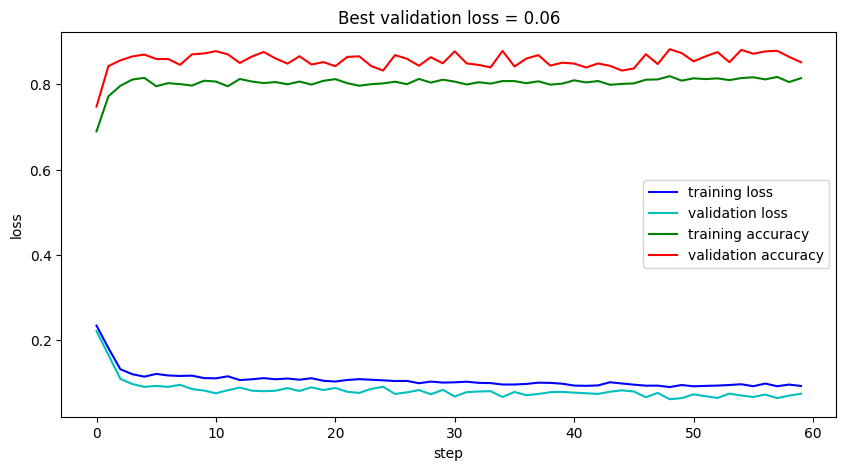

In [31]:
if TRAIN_MODEL:
  # Define trainer
  trainer = Trainer(
      network=unet_1,
      optimizer=optimizer,
      loss_function=loss_function,
      name='unet_1',
      batch_size=batch_size,
  )
  # Train model
  trainer.train_network(
      dataloader_train,
      dataloader_val,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs
  )

# 10. Testing the model

In [32]:
# The best model is load in for the test set
if TRAIN_MODEL:
  trainer_test = Trainer(network=unet_1, optimizer=None, loss_function=None, name='unet_1', batch_size=None)
else:
  trainer_test = Trainer(network=unet_1, optimizer=None, loss_function=None, name='unet_1_trained_', batch_size=None)
trainer_test.load_best_network()

In [33]:
# This function will calculate the padding to make sure that the images will be of the correct size to go through the U-net
def pad_ensure_division(h, w, division):

    def compute_pad(s, d):
        if s % d != 0:
            p = 0
            while True:
                if (s + p) % d == 0:
                    return p
                p += 1
        return 0

    py = compute_pad(h, division)
    px = compute_pad(w, division)
    padding = (py//2, py-py//2), (px//2, px-px//2)
    return padding

In [34]:
# This function will predict the segmentation masks for every image and return it together with the real segmentations
def process_unet(trainer: "Trainer", dataset: "DataSet"):
    imgs = dataset.imgs
    lbls = []
    for lbl in dataset.lbls:
      lbls.append(lbl)

    # pad image if the size is not divisable by total downsampling rate in your U-Net
    pad_imgs = []
    outputs = []
    # For each image, the image is padded and the output is predicted
    for i,img in enumerate(imgs):
      h,w,c = img.shape
      paddings = pad_ensure_division(h,w,8)
      pad_img = np.pad(img, pad_width=(paddings[0],paddings[1],(0,0)), mode='constant')
      output = trainer._predict_batch(torch.tensor(np.moveaxis(pad_img,-1,0))[None][None])

      # To be sure the real labels are also padded, so they can be compared
      lbl = lbls[i]
      lbl = np.pad(lbl,pad_width=(paddings[0],paddings[1],(0,0)), mode='constant')
      lbls[i] = lbl
      output = output[0][0]
      outputs.append(output)
    return lbls, outputs

In [35]:
lbls, outputs = process_unet(trainer_test, test_data)

In [36]:
# In this cell the recall for every segmentation class is calculated
sum_0, total_0, sum_1, total_1, sum_2, total_2 = 0,0,0,0,0,0

for i in range(len(lbls)):
  real = lbls[i][:,:,0]
  pred = np.array(torch.max(outputs[i].to('cpu'),dim=0)[1])

  #0
  sum_0 +=np.sum((real == 0) & (pred == 0))
  total_0 += np.sum(real==0)

  #1
  sum_1 +=np.sum((real == 1) & (pred == 1))
  total_1 +=  np.sum(real==1)

  #2
  sum_2 +=np.sum((real == 2) & (pred == 2))
  total_2 += np.sum(real==2)

print('Recall class 0: ',sum_0/total_0)
print('Recall class 1: ',sum_1/total_1)
print('Recall class 2: ', sum_2/total_2)

Recall class 0:  0.9823410967633239
Recall class 1:  0.0
Recall class 2:  0.20751292006273622


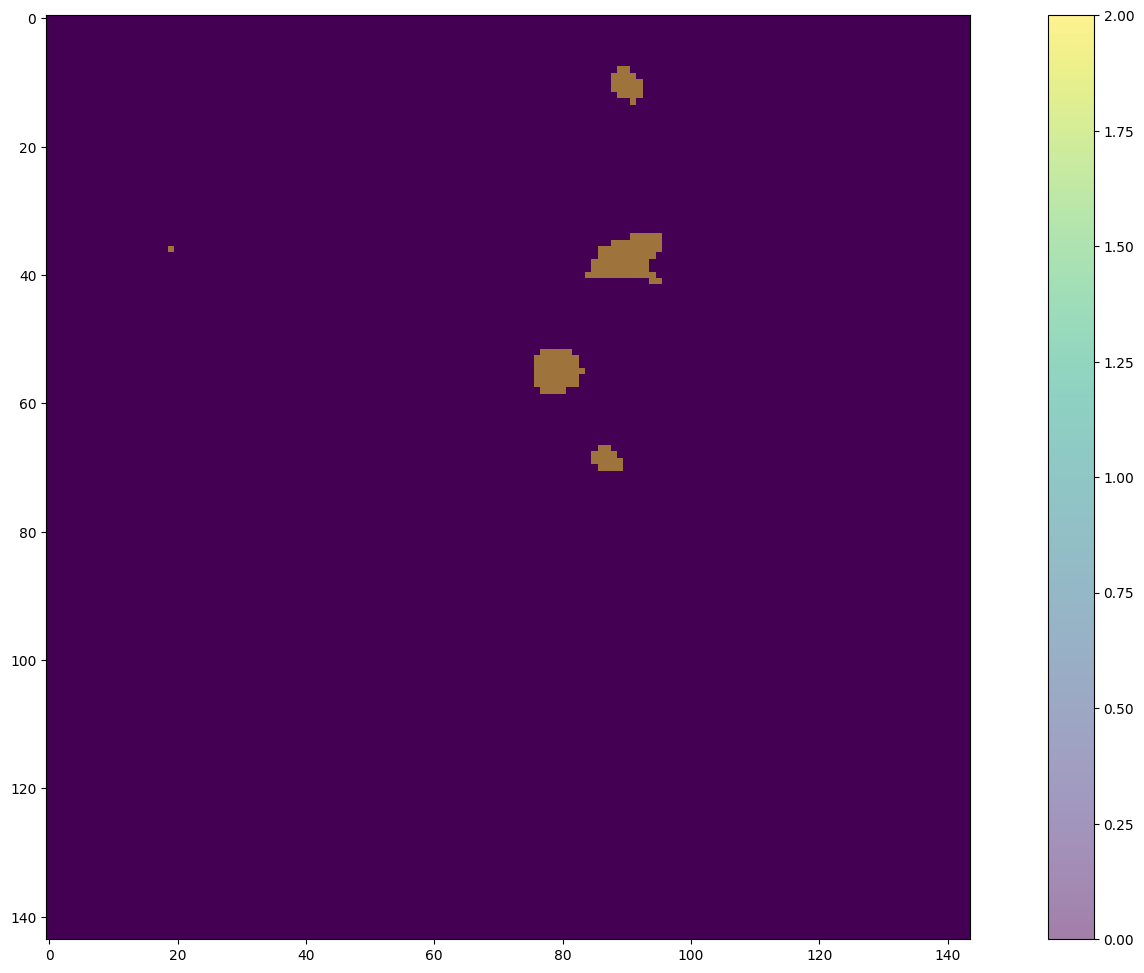

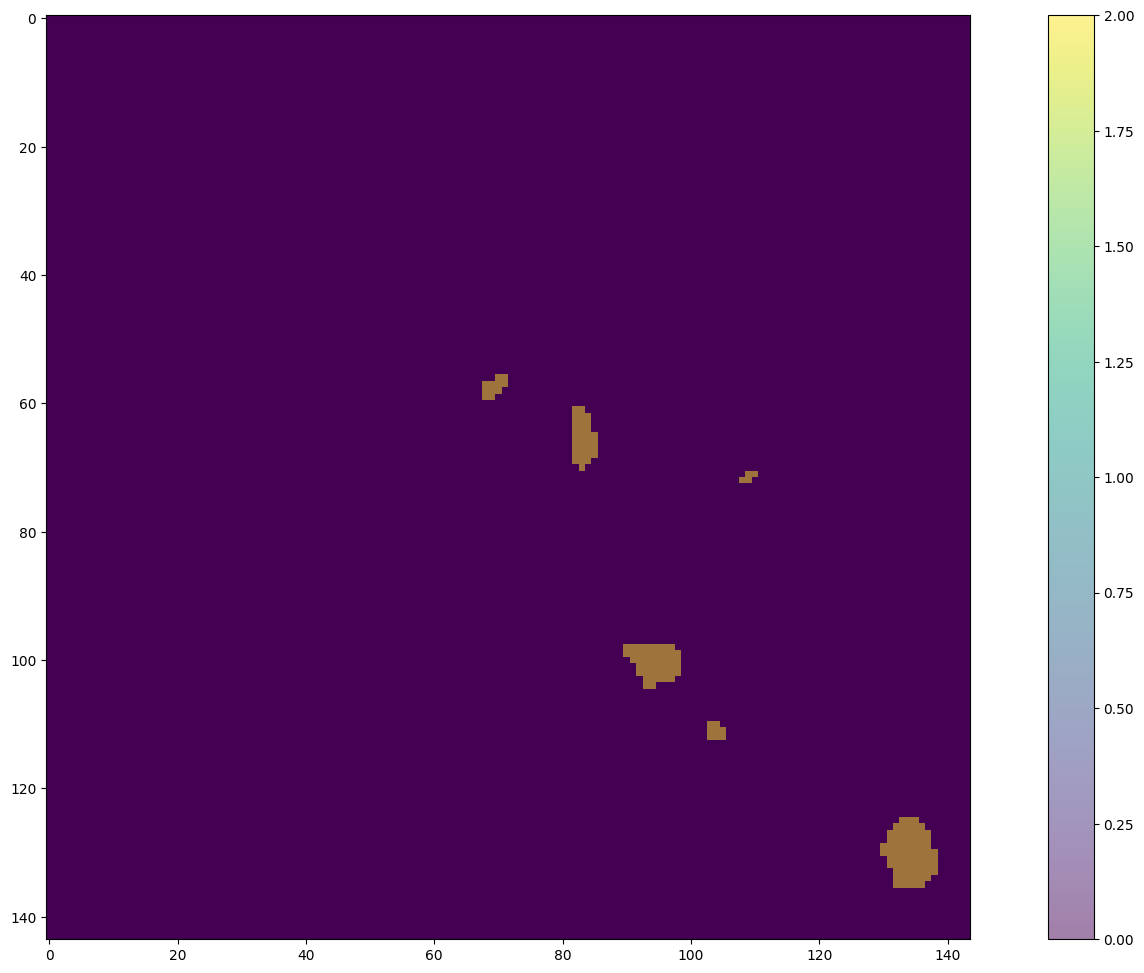

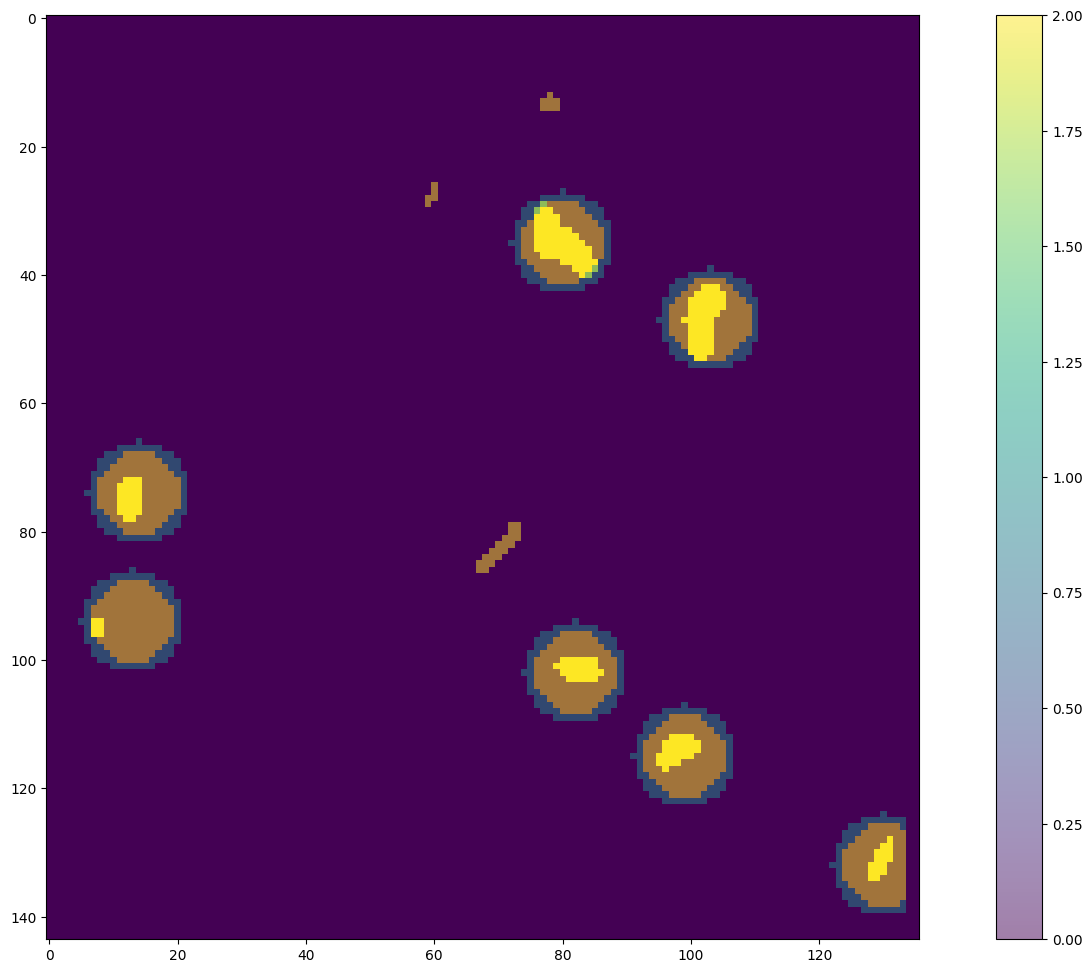

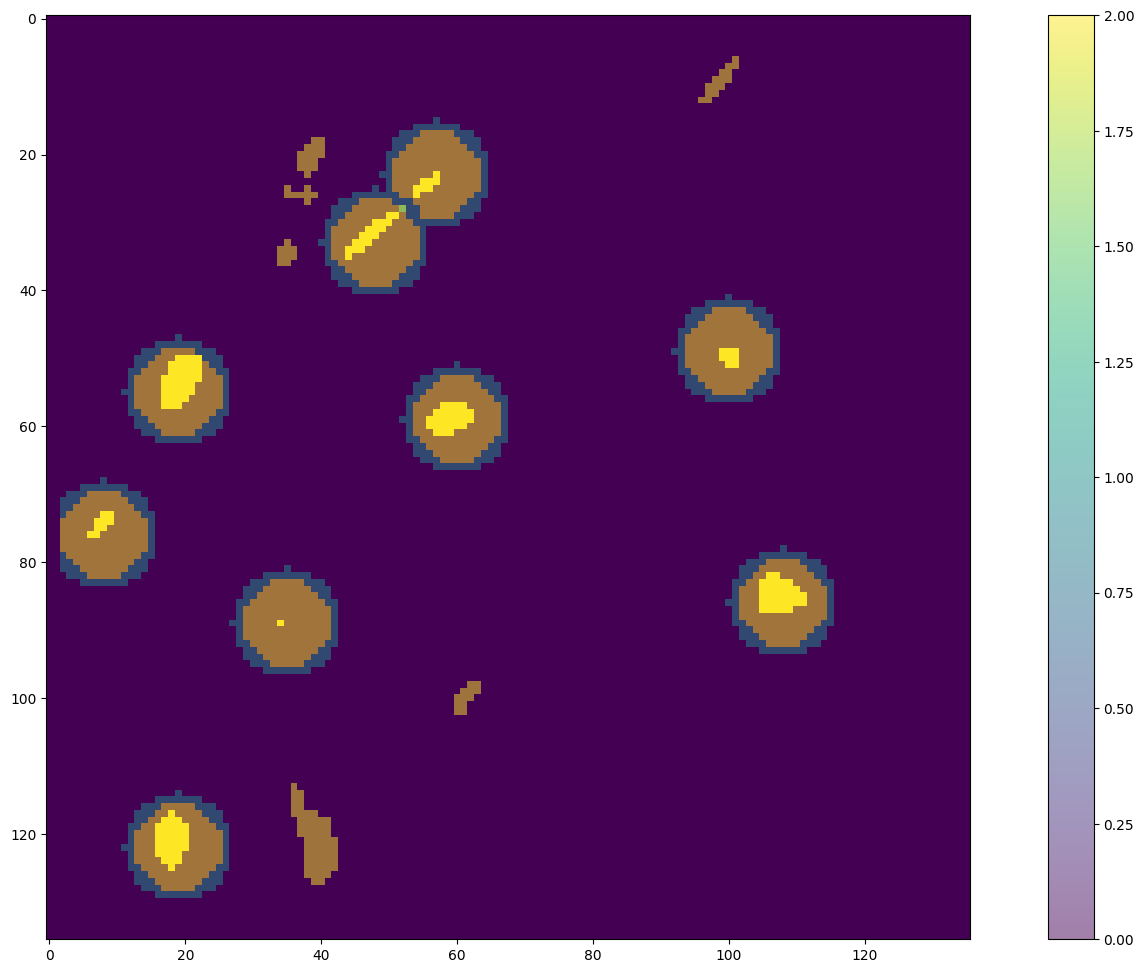

In [37]:
# A few examples will be plotted to see how good the model performed
for i in range(4):
  plt.imshow(lbls[i])
  plt.imshow(torch.max(outputs[i].to('cpu'),dim=0)[1],alpha=0.5)
  plt.colorbar()
  plt.show()

# 11. Post-Processing

In order to obtain the final detection result, likelihood maps are post-processed by smoothing with a Gaussian filter $(\sigma = 1\mu m)$ and subsequently detecting local maxima within a neighbourhood of $2.9 \mu m$. We used a Laplacian of Gaussian with a $\sigma = 2.9 \mu m$.

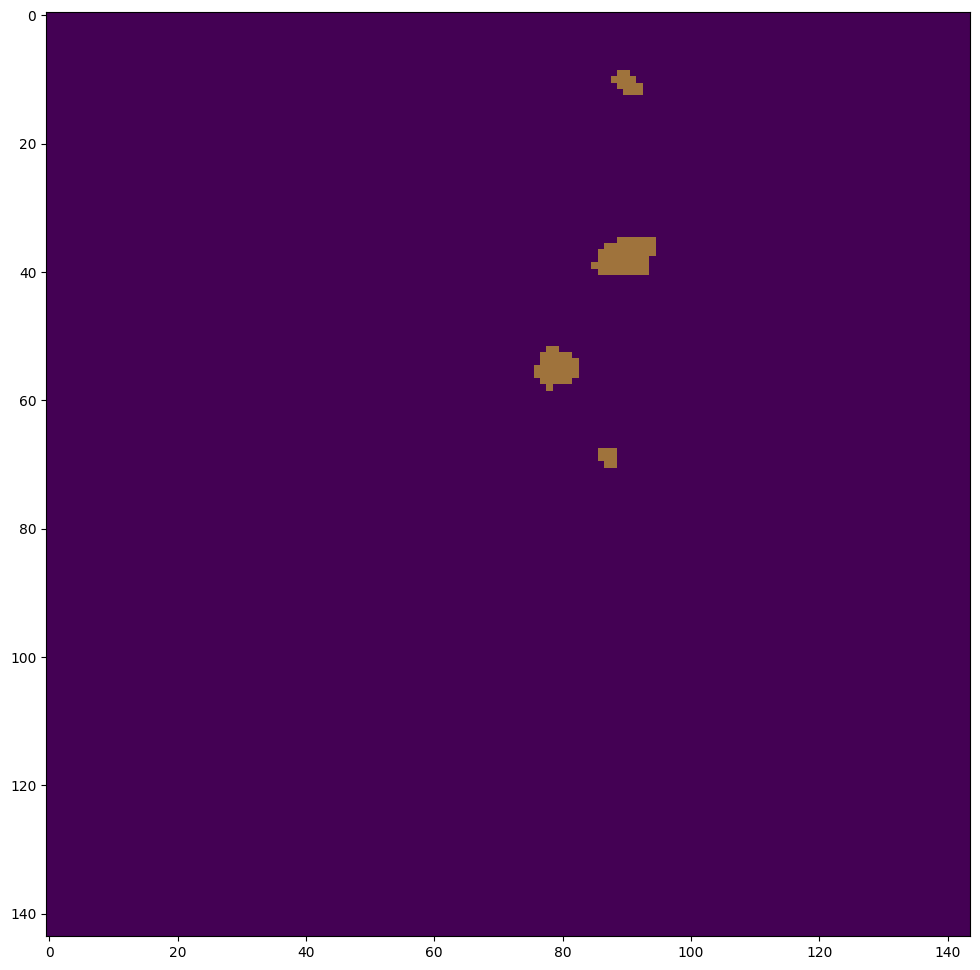

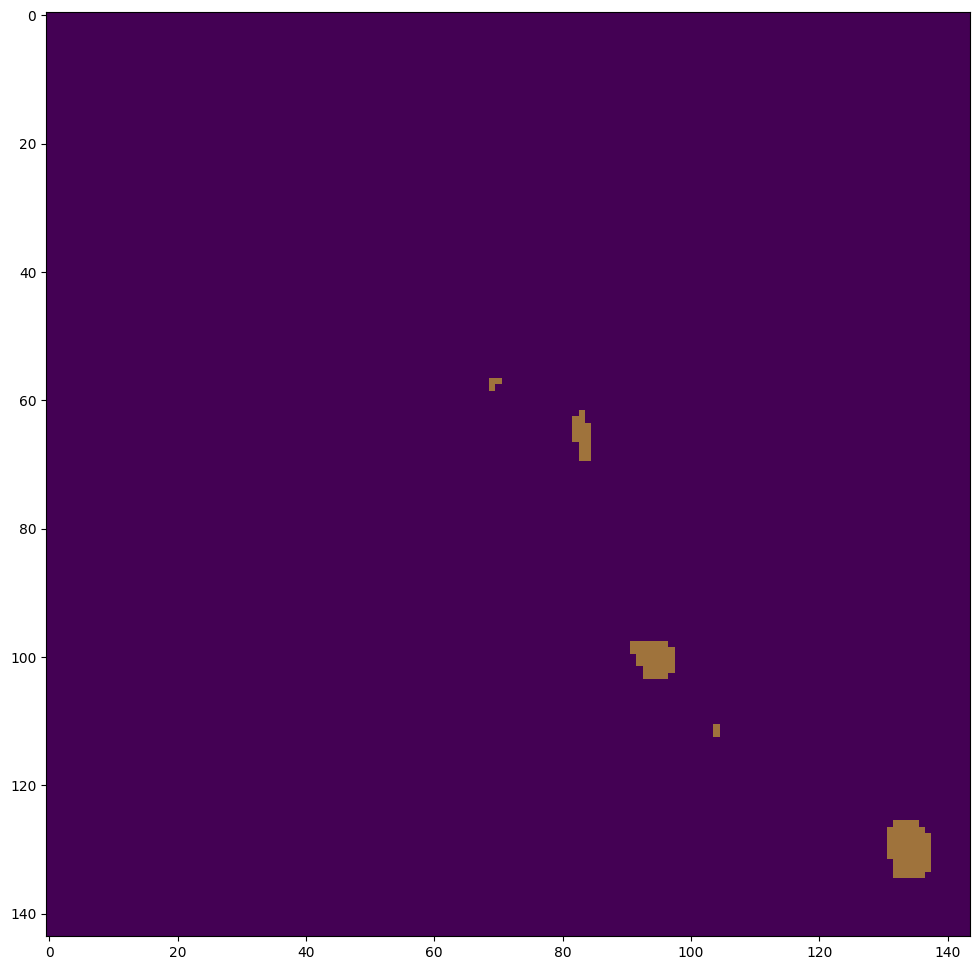

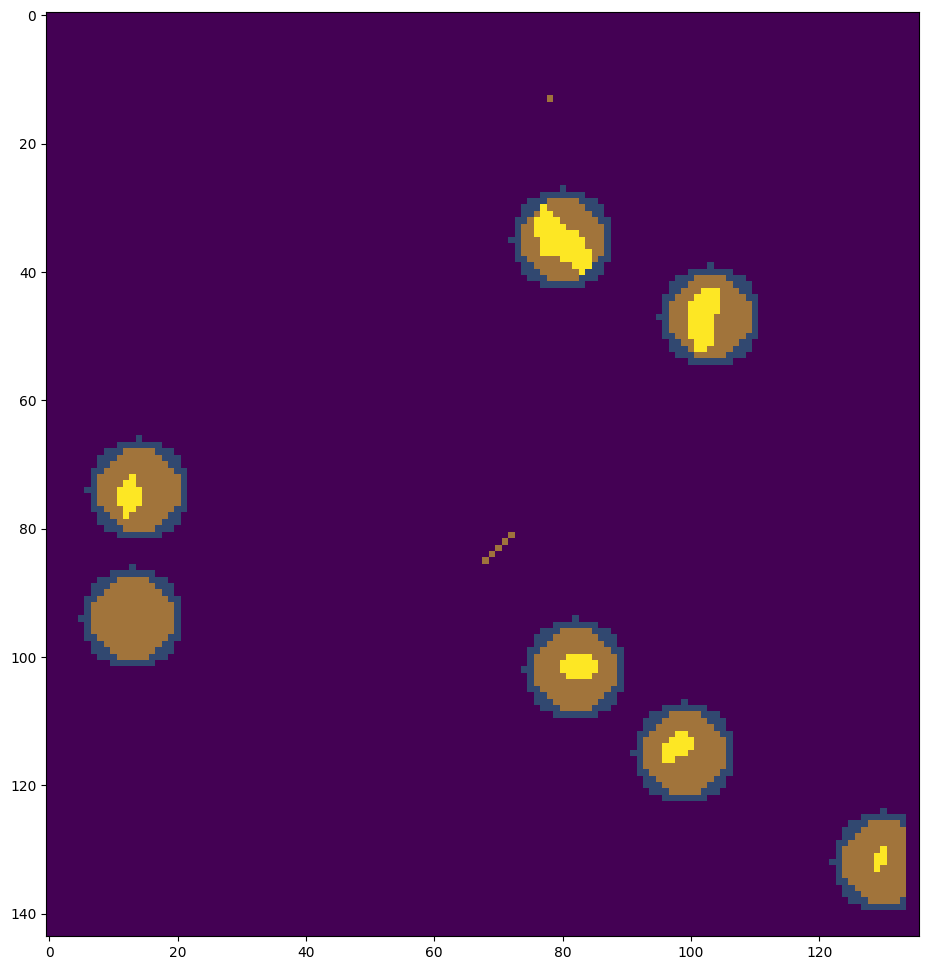

In [38]:
# smoothing
blurred_outputs = []
for output in outputs:
  tensor_np = output.cpu().numpy()
  blurred_np = np.zeros_like(tensor_np)
  for i in range(tensor_np.shape[0]):  # Iterate
    #blurred_np[0, i] = gaussian_filter(tensor_np[0, i], sigma=4) # because sigma in paper = 1 micron
    blurred_np[i] = gaussian_filter(tensor_np[i], sigma=1) # because sigma in paper = 1 micron
  blurred_tensor = torch.from_numpy(blurred_np)
  blurred_outputs.append(blurred_tensor)



for i in range(3):
  plt.imshow(lbls[i])
  plt.imshow(torch.max(blurred_outputs[i].to('cpu'),dim=0)[1],alpha=0.5)
  plt.show()

In [39]:
# creating laplacian of gaussian

def gaussian_2d(sigma_um, pixel_size_um):
    """
    Parameters
    ----------
    sigma_mm: sigma in microm
    voxel_size: the size of a voxel in microm

    Returns
    -------
    kernel: kernel
    x : matrix of x coordinates of the filter
    y : matrix of y coordinates of the filter
    """

    sigma_px = np.round(sigma_um / pixel_size_um[0])  # Convert sigma from micrometers to pixels
    kernel_size = int(sigma_px)  # Use 6*sigma as the kernel size to cover enough range of the Gaussian
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure the kernel size is odd

    # Create a grid of (kernel_size x kernel_size) for the Gaussian filter
    x, y = np.meshgrid(
        np.linspace(-kernel_size//2, kernel_size//2, kernel_size),
        np.linspace(-kernel_size//2, kernel_size//2, kernel_size)
    )

    # Calculate the Gaussian kernel
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma_px**2))
    kernel /= kernel.sum()  # Normalize the kernel

    return kernel, x, y


k, x, y = gaussian_2d(2.9, [0.25, 0.25])
def laplacian_of_gaussian(g):
    """Compute the Laplacian of Gaussian

    Parameters
    ----------
    g : 2d numpy array

    Returns
    -------
    LoG : 2d numpy array
    gxx : 2d numpy array
        Second partial derivative of g to x
    gyy : 2d numpy array
        Second partial derivative of g to y
    """
    # YOUR CODE HERE
    gxx = np.gradient(np.gradient(g, axis = 0), axis = 0)
    gyy = np.gradient(np.gradient(g, axis = 1), axis = 1)
    LoG = -1*(gxx + gyy)

    return LoG,gxx,gyy

log, gxx, gyy = laplacian_of_gaussian(k)


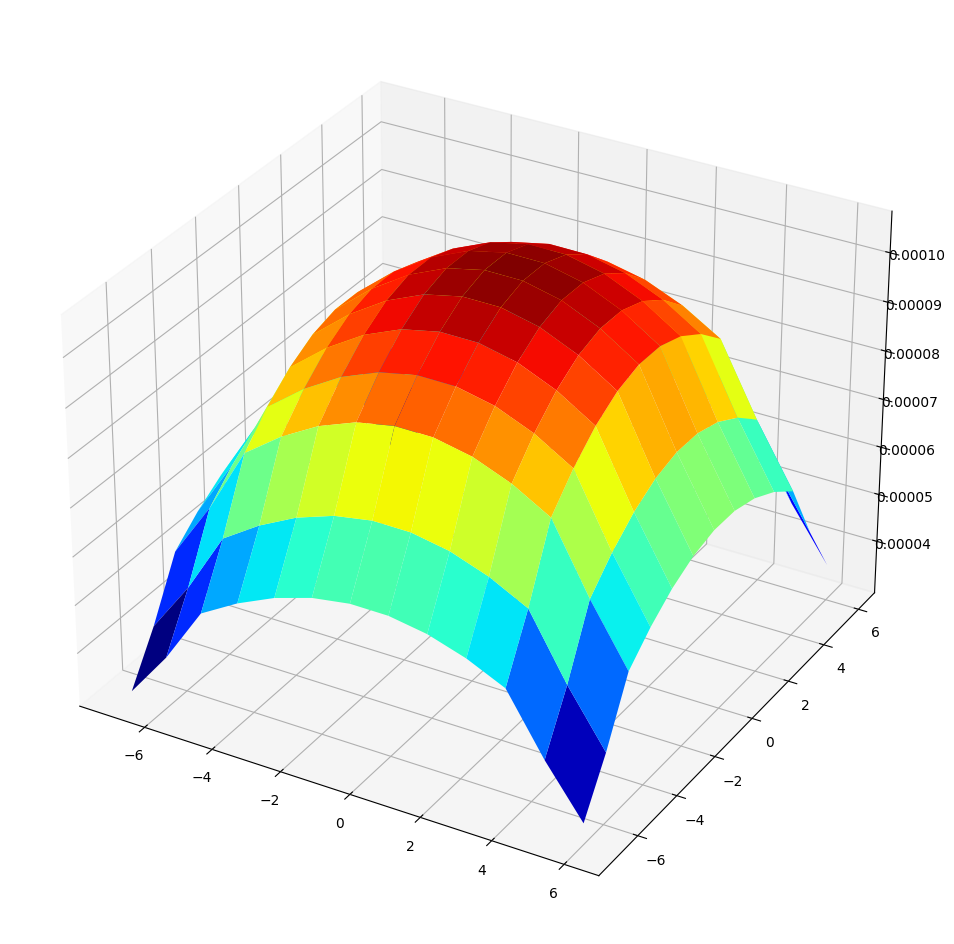

In [40]:
# visualise LoG kernel
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(x, y, log, antialiased=True, cmap=cm.jet, linewidth=0)
plt.show()

In [41]:
def find_local_maxima(tensor, sigma_um=2.9, pixel_size_um=0.25, min_distance=10):
    """
    Find local maxima in a given tensor slice using Laplacian of Gaussian (LoG) filter.

    Parameters
    ----------
    tensor : torch.Tensor
        The tensor slice to process (shape: height x width).
    sigma_um : float, optional
        Sigma in micrometers for the Gaussian filter.
    pixel_size_um : float, optional
        Size of a pixel in micrometers.
    min_distance : int, optional
        Minimum number of pixels separating peaks in a region.

    Returns
    -------
    maxima : numpy array
        Coordinates of the detected local maxima.
    """
    conv = np.zeros_like(len(tensor))
    # Convert sigma from micrometers to pixels
    sigma_px = sigma_um / pixel_size_um

    # Convert tensor to numpy array
    tensor_np = tensor.detach().cpu().numpy()

    # Apply LoG filter
    g,x,y = gaussian_2d(2.9, [0.25, 0.25])
    LoG,gxx,gyy = laplacian_of_gaussian(g)

    #LoG_output = ndimage.gaussian_laplace(tensor_np, sigma=sigma_px)

    conv = scipy.signal.convolve2d(tensor_np, LoG, mode='same')
    #plt.imshow(conv)

    # Find local maxima
    maxima = peak_local_max(conv, min_distance=min_distance, threshold_abs=0)

    return maxima

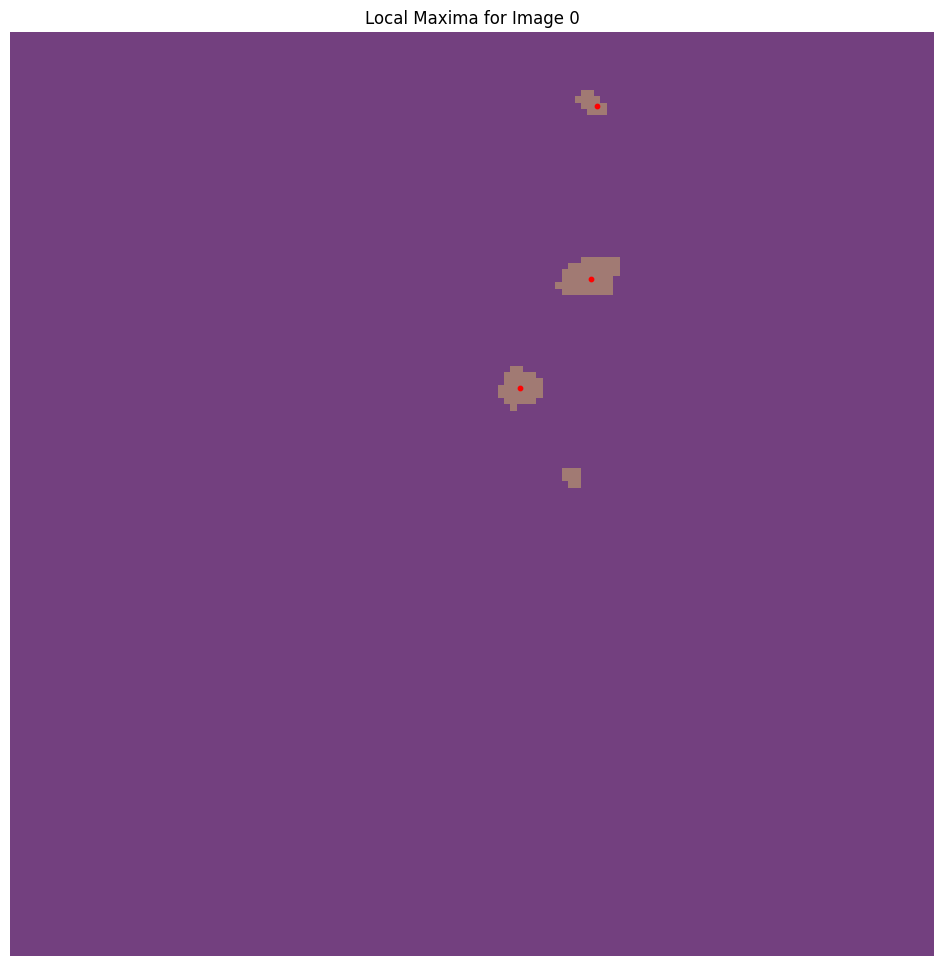

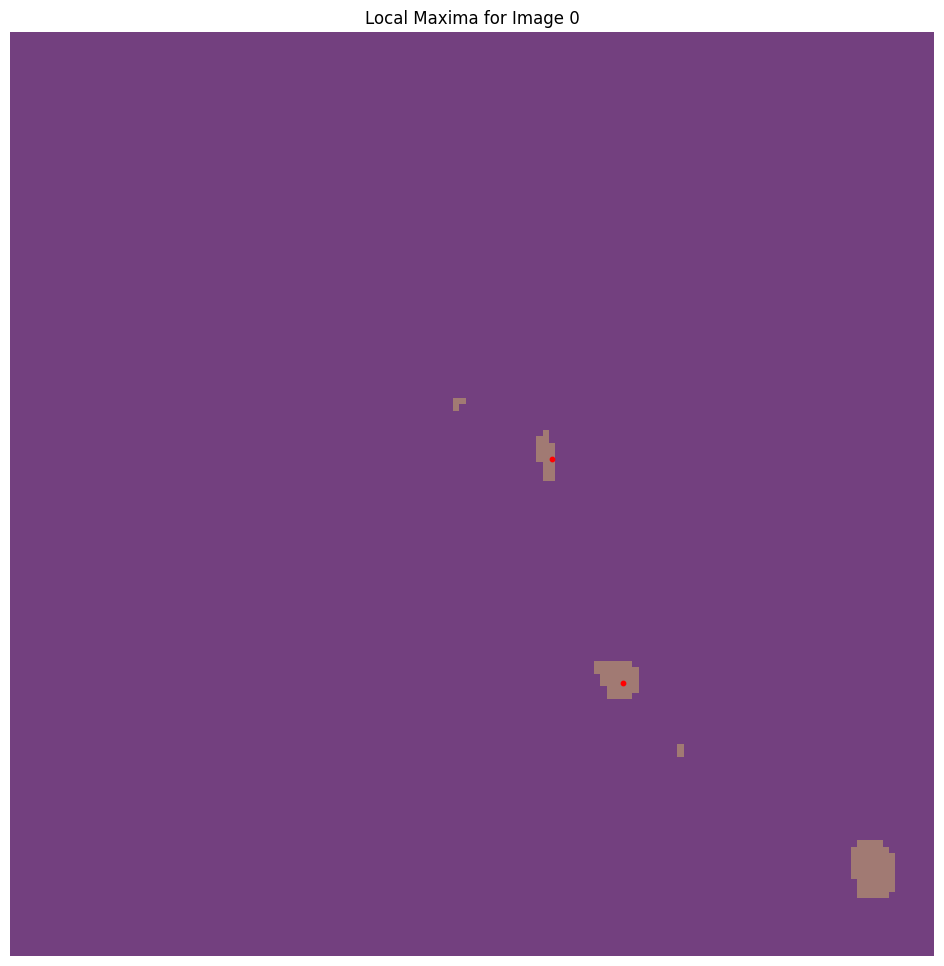

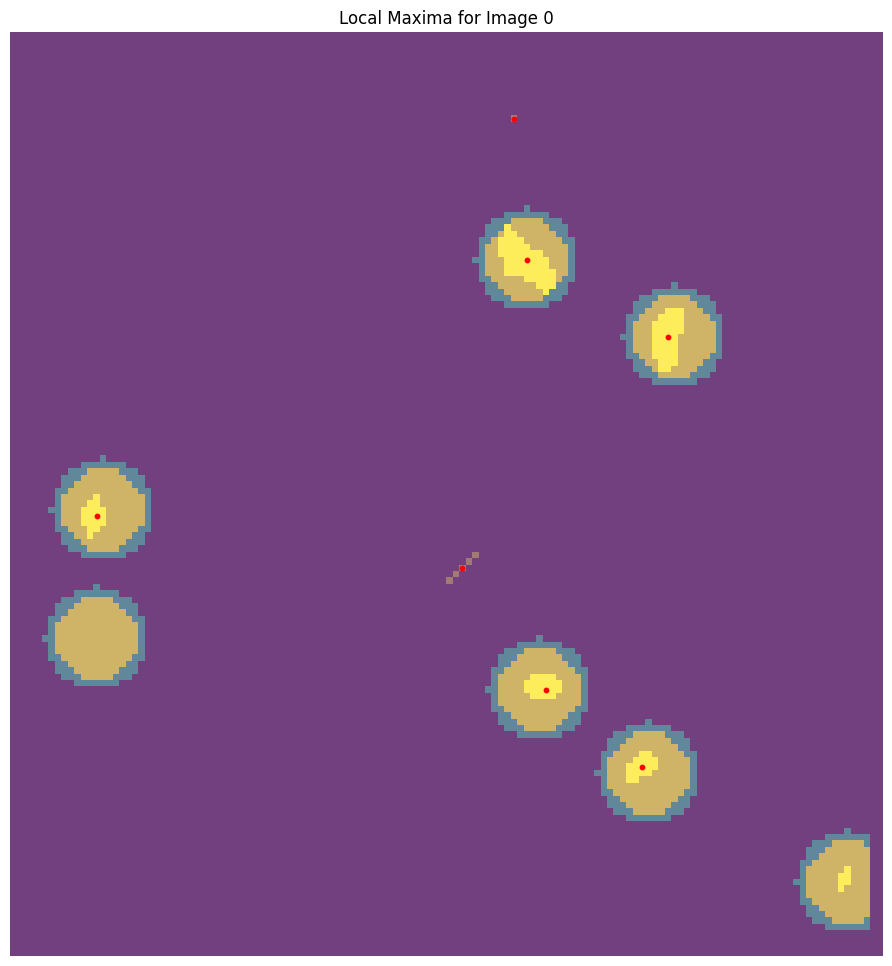

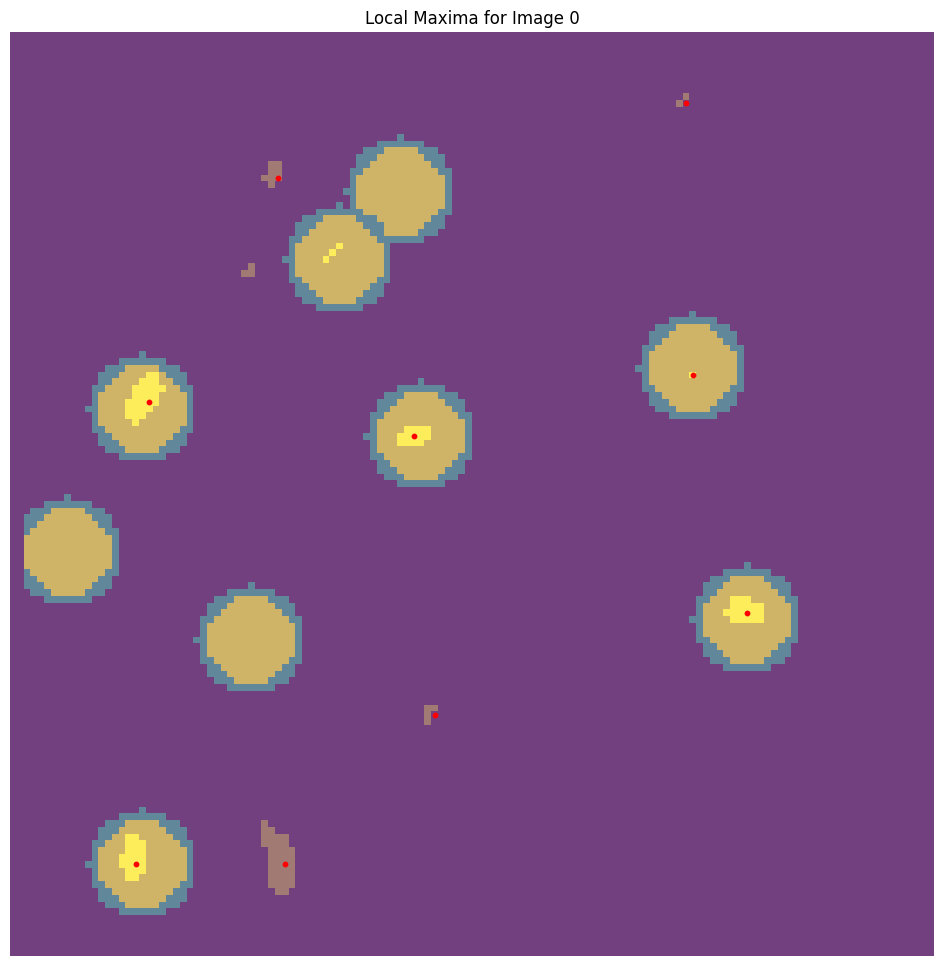

In [42]:
# visualise local maxima

for i in range(4):
  tensor_slice_2 = torch.max(blurred_outputs[i].to('cpu'),dim=0)[1]
  # Find local maxima
  local_maxima= find_local_maxima(tensor_slice_2)
  # Visualize the results
  plt.figure()
  plt.scatter(local_maxima[:, 1], local_maxima[:, 0], c='r', s=10)  # scatter plot the maxima
  plt.imshow(torch.max(blurred_outputs[i].to('cpu'),dim=0)[1],alpha=0.5)
  plt.imshow(lbls[i], alpha = 0.5)
  plt.title(f'Local Maxima for Image {0}')
  plt.axis('off')
  plt.show()


In [43]:
# end result

results = []

for j in range(len(outputs)):
  slice1 = torch.max(blurred_outputs[j].to('cpu'),dim=0)[1]
  # Find local maxima
  local_maxima = find_local_maxima(slice1)
  results.append(local_maxima)

In [44]:
def compute_metrics(local_maxima, lbls, images):
  """A function for collecting the truly predicted coordinates based on the hit criterion of the paper"""
  true_positives = 0
  false_positives = 0
  false_negatives = 0
  total_cells = 0

  # Find local maxima
  print(len(local_maxima))
  images = images.imgs
  count = 0
  for i in range(len(local_maxima)): # loop over images
    pred_coords = local_maxima[i] # predicted coordinates of lymphocite centers
    lbl_coords = np.column_stack(np.where(lbls[i].squeeze() > 0)) # all coordinates where a lymphocite is (labeled as 1 or 2)

    if len(lbl_coords) == 0: # if no lymphocites are present in the image
      print(f"No labeled coordinates found in image {i}.")
      false_positives += len(pred_coords)
      continue


    image_area = images[i].shape[0] * images[i].shape[1]  #len(lbls[i][0,:,:]) * len(lbls[i][:,0,:]) # total of image


    tp = 0
    fp = 0
    fn = 0
    tn = 0

    new_coords = []
    for pred_coord in pred_coords:
      x, y = pred_coord
      for i in range(-12, 12+1):   # based on 2.8 um
        for j in range(-12, 12+1):
          new_coord = np.array([x + i, y + j])
          new_coords.append(new_coord)

    detected_labels = np.zeros(len(lbl_coords), dtype=bool)
    detect_lbls = 0
    for new_coord in new_coords:
      dis = np.linalg.norm(lbl_coords - new_coord, axis = 1) # euclidean distance
      min_dis_idx = np.argmin(dis) # index of of the ground truth cell that is closest to the predicted cell
      min_dis = dis[min_dis_idx]

      if min_dis <= 0:

        detected_labels[min_dis_idx] = True

        tp += 1
        detect_lbls += 1
      else:
        fp += 1


    fn = np.sum(~detected_labels) # any ground truth cell that is not detected (detected_labels remains False)

    # cummulative numbers
    true_positives += tp
    false_positives += fp
    false_negatives += fn
    total_cells += image_area

  print('tp:', true_positives)
  print('fp:', false_positives)
  print('fn:', false_negatives)
  print('total:', total_cells)
  # calculate precision, recall etc.
  true_negatives = total_cells - (true_positives + false_positives + false_negatives)
  precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
  recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  print('tn: ', true_negatives)

  return precision, recall, f1, true_positives, true_negatives, false_negatives, false_positives

In [45]:
precision, recall, f1, true_positives, true_negatives, false_negatives, false_positives = compute_metrics(results, lbls, test_data)

180
No labeled coordinates found in image 0.
No labeled coordinates found in image 1.
No labeled coordinates found in image 6.
No labeled coordinates found in image 7.
No labeled coordinates found in image 9.
No labeled coordinates found in image 10.
No labeled coordinates found in image 14.
No labeled coordinates found in image 17.
No labeled coordinates found in image 20.
No labeled coordinates found in image 21.
No labeled coordinates found in image 24.
No labeled coordinates found in image 25.
No labeled coordinates found in image 27.
No labeled coordinates found in image 29.
No labeled coordinates found in image 32.
No labeled coordinates found in image 34.
No labeled coordinates found in image 36.
No labeled coordinates found in image 38.
No labeled coordinates found in image 42.
No labeled coordinates found in image 44.
No labeled coordinates found in image 59.
No labeled coordinates found in image 60.
No labeled coordinates found in image 61.
No labeled coordinates found in ima

In [46]:
print('Precision: ', precision)
print('F1-score: ', f1)
print('Recall: ', recall)

Precision:  0.14766926036844633
F1-score:  0.2401609409642766
Recall:  0.6427318607980222
